In [1]:
import pandas as pd
import numpy as np
from typing import List, Optional

In [2]:
def load_data(path: str, na_values: Optional[List[str]] = None) -> pd.DataFrame:
    """Load CSV with sensible NA placeholders."""
    if na_values is None:
        na_values = ["-", "", "NA", "NaN", "nan", None]
    df = pd.read_csv(path, na_values=na_values, dtype=str, low_memory=False)
    return df

In [3]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Lowercase column names and replace spaces/special chars with underscores."""
    df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ", "_").replace("-", "_"))
    return df

In [4]:
def replace_placeholders(df: pd.DataFrame, placeholders: List[str] = None) -> pd.DataFrame:
    """Replace common placeholders with np.nan."""
    if placeholders is None:
        placeholders = ["-", ""]
    return df.replace(placeholders + ["None", "none"], np.nan)

In [5]:
def trim_and_normalize_text(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Strip whitespace, collapse multiple spaces, and fix capitalization for text columns."""
    for c in cols:
        if c in df.columns:
            # safe conversion to string for trimming, then put back np.nan where it was NaN
            original_na = df[c].isna()
            df[c] = df[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
            # avoid turning "nan" strings into real values
            df.loc[df[c].isin(["nan", "None", "none", "NaN"]), c] = np.nan
            df.loc[original_na, c] = np.nan
    return df

In [6]:
def clean_species_canonical(name: str) -> Optional[str]:
    """
    Normalize species canonical names:
     - Keep Genus capitalized, species epithet lowercase (e.g. 'Homo sapiens')
     - Leave multi-word epithets (subspecies) intact
    """
    if pd.isna(name):
        return np.nan
    # remove extra whitespace
    name = " ".join(str(name).split())
    parts = name.split(" ")
    if len(parts) == 0:
        return np.nan
    # Genus: title-case; other parts: lowercase
    genus = parts[0].capitalize()
    rest = " ".join([p.lower() for p in parts[1:]]) if len(parts) > 1 else ""
    return (genus + (" " + rest if rest else "")).strip()

In [7]:
def convert_numeric_columns(df: pd.DataFrame, numeric_cols: List[str]) -> pd.DataFrame:
    """Convert list of columns to numeric (float) with coercion."""
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

In [8]:
def convert_integer_columns(df: pd.DataFrame, int_cols: List[str]) -> pd.DataFrame:
    """Convert columns to integers when possible (after filling NA if desired)."""
    for c in int_cols:
        if c in df.columns:
            # safe conversion: coerce -> round -> Int64 (nullable integer)
            df[c] = pd.to_numeric(df[c], errors="coerce").round().astype("Int64")
    return df

In [9]:
def convert_boolean_flags(df: pd.DataFrame, flag_cols: List[str]) -> pd.DataFrame:
    """Convert environment flags to 0/1 integers and boolean dtype."""
    for c in flag_cols:
        if c in df.columns:
            # some values may be floats like 1.0, or '1' strings
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
            df[c] = df[c].apply(lambda x: 1 if float(x) != 0 else 0).astype("int8")
    return df

In [10]:
def convert_datetime_columns(df: pd.DataFrame, dt_cols: List[str]) -> pd.DataFrame:
    for c in dt_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

In [11]:
def report_duplicates(df: pd.DataFrame, subset: List[str]) -> pd.DataFrame:
    """Return a DataFrame showing duplicate groups for inspection."""
    dup_mask = df.duplicated(subset=subset, keep=False)
    return df.loc[dup_mask].sort_values(by=subset)

In [12]:
def drop_duplicates(df: pd.DataFrame, subset: List[str], keep: str = "first"):
    """Drop duplicates in-place and return the new df."""
    before = df.shape[0]
    df = df.drop_duplicates(subset=subset, keep=keep)
    after = df.shape[0]
    print(f"Dropped {before-after} duplicate rows based on {subset}.")
    return df

In [13]:
def drop_high_missing(df: pd.DataFrame, thresh: float = 0.8) -> pd.DataFrame:
    """
    Drop columns with > thresh fraction missing (e.g., 0.8 -> drop columns with >80% missing).
    Returns a reduced df.
    """
    missing_frac = df.isna().mean()
    to_drop = missing_frac[missing_frac > thresh].index.tolist()
    if to_drop:
        print(f"Dropping columns with >{thresh*100:.0f}% missing: {to_drop}")
        df = df.drop(columns=to_drop)
    return df

In [14]:
def impute_numeric_by_group(df: pd.DataFrame, cols: List[str], group_col: str = "genus") -> pd.DataFrame:
    """
    For each numeric col, impute missing by the group's median (group_col), else overall median.
    This preserves biological signal (e.g., genus).
    """
    for col in cols:
        if col not in df.columns:
            continue
        # overall median
        overall_med = df[col].median(skipna=True)
        # group median
        if group_col in df.columns:
            med_by_group = df.groupby(group_col)[col].median()
            def fill_fn(row):
                if pd.notna(row[col]):
                    return row[col]
                g = row.get(group_col, np.nan)
                if pd.isna(g):
                    return overall_med
                gm = med_by_group.get(g, np.nan)
                return gm if pd.notna(gm) else overall_med
            df[col] = df.apply(fill_fn, axis=1)
        else:
            df[col] = df[col].fillna(overall_med)
    return df

In [15]:
def impute_categorical(df: pd.DataFrame, cols: List[str], fill_value: str = "Unknown") -> pd.DataFrame:
    for col in cols:
        if col in df.columns:
            df[col] = df[col].fillna(fill_value)
    return df

In [16]:
def clean_species_dataset(input_path: str,
                          output_path: Optional[str] = None,
                          drop_missing_col_threshold: float = 0.95,
                          impute_numeric_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Main pipeline:
      1. Load
      2. Standardize column names
      3. Replace placeholders and trim text
      4. Convert dtypes (numeric, int, flags, datetime)
      5. Normalize species canonical names
      6. Drop columns with extreme missingness (optional)
      7. Impute numerics by genus median then overall median
      8. Impute categorical with 'Unknown'
      9. Remove duplicates (by species_canonical)
     10. Save cleaned CSV (if output_path provided)
    """
    # 1. Load
    INPUT = r"new_final_species.csv"
    OUTPUT = r"new_final_species_cleaned.csv"
    df = load_data(input_path)

    # 2. Standardize column names
    df = standardize_column_names(df)

    # quick diagnostics
    print("Initial shape:", df.shape)
    print("Columns:", df.columns.tolist())

    # 3. Replace placeholder tokens with NaN
    df = replace_placeholders(df, placeholders=["-"])

    # 4. Trim text columns (apply to all object columns)
    text_cols = df.select_dtypes(include="object").columns.tolist()
    df = trim_and_normalize_text(df, text_cols)

    # 5. Normalize taxonomic names: species_canonical & genus
    if "species_canonical" in df.columns:
        df["species_canonical"] = df["species_canonical"].apply(clean_species_canonical)
    if "genus" in df.columns:
        df["genus"] = df["genus"].astype(str).str.strip().replace({"nan": np.nan}).apply(lambda x: x.capitalize() if pd.notna(x) else np.nan)

    # 6. Convert numeric cols (update this list as needed)
    # If you want to auto-detect numeric-like columns, you can attempt to convert many columns.
    default_numeric = [
        "aphia_id", "ncbi_taxon_id", "spec_code",
        "depth_min_in_m", "depth_max_in_m", "common_depth_min", "common_depth_max",
        "length_max_in_cm", "common_length_in_cm", "weight_max_in_g",
        "tempmin", "tempmax"
    ]
    # keep only those present
    numeric_to_convert = [c for c in default_numeric if c in df.columns]
    df = convert_numeric_columns(df, numeric_to_convert)

    # 7. Convert id-like columns to integer (nullable Int64)
    int_cols = [c for c in ["aphia_id", "ncbi_taxon_id", "spec_code"] if c in df.columns]
    df = convert_integer_columns(df, int_cols)

    # 8. Convert boolean flags
    flag_cols = [c for c in ["ismarine", "isbrackish", "isfreshwater", "isterrestrial", "isextinct"] if c in df.columns]
    df = convert_boolean_flags(df, flag_cols)

    # 9. Convert datetime columns
    dt_cols = [c for c in ["modified", "date_modified", "date"] if c in df.columns]
    df = convert_datetime_columns(df, dt_cols)

    # 10. Drop columns with too much missing data
    df = drop_high_missing(df, thresh=drop_missing_col_threshold)

    # 11. Impute numeric columns by genus median, else overall median
    if impute_numeric_cols is None:
        impute_numeric_cols = [c for c in numeric_to_convert if c in df.columns]
    df = impute_numeric_by_group(df, impute_numeric_cols, group_col="genus")

    # 12. Impute categoricals for a handful of fields often used in analysis
    cat_fill = [c for c in ["family_x", "authority", "rank", "order", "subspecies", "sequencing_status", "target_list_status"] if c in df.columns]
    df = impute_categorical(df, cat_fill, fill_value="Unknown")

    # 13. Remove exact duplicate species_canonical rows (keep first)
    if "species_canonical" in df.columns:
        before = df.shape[0]
        df = drop_duplicates(df, subset=["species_canonical"], keep="first")
        after = df.shape[0]

    # final diagnostics
    print("Final shape:", df.shape)
    missing_summary = df.isna().sum().sort_values(ascending=False)
    print("Top 15 columns by missing count:\n", missing_summary.head(15))

    # 14. Save cleaned file
    if output_path:
        df.to_csv(output_path, index=False)
        print("Saved cleaned dataset to:", output_path)

    return df

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    INPUT = "/mnt/data/new_final_species.csv"   # change if your file lives elsewhere
    OUTPUT = "/mnt/data/new_final_species_cleaned.csv"
    cleaned_df = clean_species_dataset(INPUT, OUTPUT, drop_missing_col_threshold=0.95)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/new_final_species.csv'

In [17]:
import os
for dirname, _, filenames in os.walk('/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/plugins/mpec1.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/plugins/mpec3.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/plugins/solver2.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/plugins/solver1.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/plugins/__init__.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/plugins/mpec4.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/tests/test_nlp.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/tests/test_complementarity.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/tests/test_minlp.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/tests/test_path.py
/usr/local/lib/python3.12/dist-packages/pyomo/mpec/tests/__init__.py
/usr/local/lib/python3.12/dist-packages/pyomo/contrib/__init__.py
/usr/local/lib/python3.12/dist-packages/pyomo/contrib/solver/plugins.py
/usr/local/lib/python3.12/dist-packa

KeyboardInterrupt: 

In [18]:
# Step-by-step data cleaning for species dataset
import pandas as pd
import numpy as np
from typing import List, Optional

# -----------------------------
# Utility helpers
# -----------------------------
def load_data(path: str, na_values: Optional[List[str]] = None) -> pd.DataFrame:
    """Load CSV with sensible NA placeholders."""
    if na_values is None:
        na_values = ["-", "", "NA", "NaN", "nan", None]
    df = pd.read_csv(path, na_values=na_values, dtype=str, low_memory=False)
    return df

def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Lowercase column names and replace spaces/special chars with underscores."""
    df = df.rename(columns=lambda c: str(c).strip().lower().replace(" ", "_").replace("-", "_"))
    return df

def replace_placeholders(df: pd.DataFrame, placeholders: List[str] = None) -> pd.DataFrame:
    """Replace common placeholders with np.nan."""
    if placeholders is None:
        placeholders = ["-", ""]
    return df.replace(placeholders + ["None", "none"], np.nan)

def trim_and_normalize_text(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Strip whitespace, collapse multiple spaces, and fix capitalization for text columns."""
    for c in cols:
        if c in df.columns:
            original_na = df[c].isna()
            df[c] = df[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
            df.loc[df[c].isin(["nan", "None", "none", "NaN"]), c] = np.nan
            df.loc[original_na, c] = np.nan
    return df

def clean_species_canonical(name: str) -> Optional[str]:
    """Normalize species canonical names: Genus capitalized, epithet lowercase."""
    if pd.isna(name):
        return np.nan
    name = " ".join(str(name).split())
    parts = name.split(" ")
    if len(parts) == 0:
        return np.nan
    genus = parts[0].capitalize()
    rest = " ".join([p.lower() for p in parts[1:]]) if len(parts) > 1 else ""
    return (genus + (" " + rest if rest else "")).strip()

# -----------------------------
# Type conversion
# -----------------------------
def convert_numeric_columns(df: pd.DataFrame, numeric_cols: List[str]) -> pd.DataFrame:
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def convert_integer_columns(df: pd.DataFrame, int_cols: List[str]) -> pd.DataFrame:
    for c in int_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").round().astype("Int64")
    return df

def convert_boolean_flags(df: pd.DataFrame, flag_cols: List[str]) -> pd.DataFrame:
    for c in flag_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
            df[c] = df[c].apply(lambda x: 1 if float(x) != 0 else 0).astype("int8")
    return df

def convert_datetime_columns(df: pd.DataFrame, dt_cols: List[str]) -> pd.DataFrame:
    for c in dt_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

# -----------------------------
# Duplicate handling
# -----------------------------
def drop_duplicates(df: pd.DataFrame, subset: List[str], keep: str = "first"):
    before = df.shape[0]
    df = df.drop_duplicates(subset=subset, keep=keep)
    after = df.shape[0]
    print(f"Dropped {before-after} duplicate rows based on {subset}.")
    return df

# -----------------------------
# Missing value handling
# -----------------------------
def drop_high_missing(df: pd.DataFrame, thresh: float = 0.8) -> pd.DataFrame:
    missing_frac = df.isna().mean()
    to_drop = missing_frac[missing_frac > thresh].index.tolist()
    if to_drop:
        print(f"Dropping columns with >{thresh*100:.0f}% missing: {to_drop}")
        df = df.drop(columns=to_drop)
    return df

def impute_numeric_by_group(df: pd.DataFrame, cols: List[str], group_col: str = "genus") -> pd.DataFrame:
    for col in cols:
        if col not in df.columns:
            continue
        overall_med = df[col].median(skipna=True)
        if group_col in df.columns:
            med_by_group = df.groupby(group_col)[col].median()
            def fill_fn(row):
                if pd.notna(row[col]):
                    return row[col]
                g = row.get(group_col, np.nan)
                if pd.isna(g):
                    return overall_med
                gm = med_by_group.get(g, np.nan)
                return gm if pd.notna(gm) else overall_med
            df[col] = df.apply(fill_fn, axis=1)
        else:
            df[col] = df[col].fillna(overall_med)
    return df

def impute_categorical(df: pd.DataFrame, cols: List[str], fill_value: str = "Unknown") -> pd.DataFrame:
    for col in cols:
        if col in df.columns:
            df[col] = df[col].fillna(fill_value)
    return df

# -----------------------------
# Main cleaning pipeline
# -----------------------------
def clean_species_dataset(input_path: str,
                          output_path: Optional[str] = None,
                          drop_missing_col_threshold: float = 0.95,
                          impute_numeric_cols: Optional[List[str]] = None) -> pd.DataFrame:
    # 1. Load
    df = load_data(input_path)

    # 2. Standardize names
    df = standardize_column_names(df)

    print("Initial shape:", df.shape)

    # 3. Replace placeholders
    df = replace_placeholders(df, placeholders=["-"])

    # 4. Trim text
    text_cols = df.select_dtypes(include="object").columns.tolist()
    df = trim_and_normalize_text(df, text_cols)

    # 5. Normalize species/genus names
    if "species_canonical" in df.columns:
        df["species_canonical"] = df["species_canonical"].apply(clean_species_canonical)
    if "genus" in df.columns:
        df["genus"] = df["genus"].astype(str).str.strip().replace({"nan": np.nan}).apply(lambda x: x.capitalize() if pd.notna(x) else np.nan)

    # 6. Convert numerics
    default_numeric = [
        "aphia_id", "ncbi_taxon_id", "spec_code",
        "depth_min_in_m", "depth_max_in_m", "common_depth_min", "common_depth_max",
        "length_max_in_cm", "common_length_in_cm", "weight_max_in_g",
        "tempmin", "tempmax"
    ]
    numeric_to_convert = [c for c in default_numeric if c in df.columns]
    df = convert_numeric_columns(df, numeric_to_convert)

    # 7. Integer conversion
    int_cols = [c for c in ["aphia_id", "ncbi_taxon_id", "spec_code"] if c in df.columns]
    df = convert_integer_columns(df, int_cols)

    # 8. Boolean flags
    flag_cols = [c for c in ["ismarine", "isbrackish", "isfreshwater", "isterrestrial", "isextinct"] if c in df.columns]
    df = convert_boolean_flags(df, flag_cols)

    # 9. Datetime conversion
    dt_cols = [c for c in ["modified"] if c in df.columns]
    df = convert_datetime_columns(df, dt_cols)

    # 10. Drop high missing
    df = drop_high_missing(df, thresh=drop_missing_col_threshold)

    # 11. Impute numeric
    if impute_numeric_cols is None:
        impute_numeric_cols = [c for c in numeric_to_convert if c in df.columns]
    df = impute_numeric_by_group(df, impute_numeric_cols, group_col="genus")

    # 12. Impute categoricals
    cat_fill = [c for c in ["family_x", "authority", "rank", "order", "subspecies", "sequencing_status", "target_list_status"] if c in df.columns]
    df = impute_categorical(df, cat_fill, fill_value="Unknown")

    # 13. Drop duplicates
    if "species_canonical" in df.columns:
        df = drop_duplicates(df, subset=["species_canonical"], keep="first")

    print("Final shape:", df.shape)
    print("Missing values summary:\n", df.isna().sum().sort_values(ascending=False).head(10))

    # 14. Save cleaned file
    if output_path:
        df.to_csv(output_path, index=False)
        print("Saved cleaned dataset to:", output_path)

    return df

# -----------------------------
# Run the cleaning
# -----------------------------
if __name__ == "__main__":
    INPUT = "new_final_species.csv"    # assumes file is in same folder
    OUTPUT = "new_final_species_cleaned.csv"
    cleaned_df = clean_species_dataset(INPUT, OUTPUT, drop_missing_col_threshold=0.95)


Initial shape: (19686, 33)


/tmp/ipython-input-412280669.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(placeholders + ["None", "none"], np.nan)


Dropping columns with >95% missing: ['publication_id', 'subspecies', 'sequencing_status', 'tempmin', 'tempmax']
Dropped 1 duplicate rows based on ['species_canonical'].
Final shape: (19685, 28)
Missing values summary:
 all_synonyms         11740
subfamily            10791
fbname                6977
demerspelag           1570
genus                 1570
status                  43
modified                43
family_x                 0
species_canonical        0
ncbi_taxon_id            0
dtype: int64
Saved cleaned dataset to: new_final_species_cleaned.csv


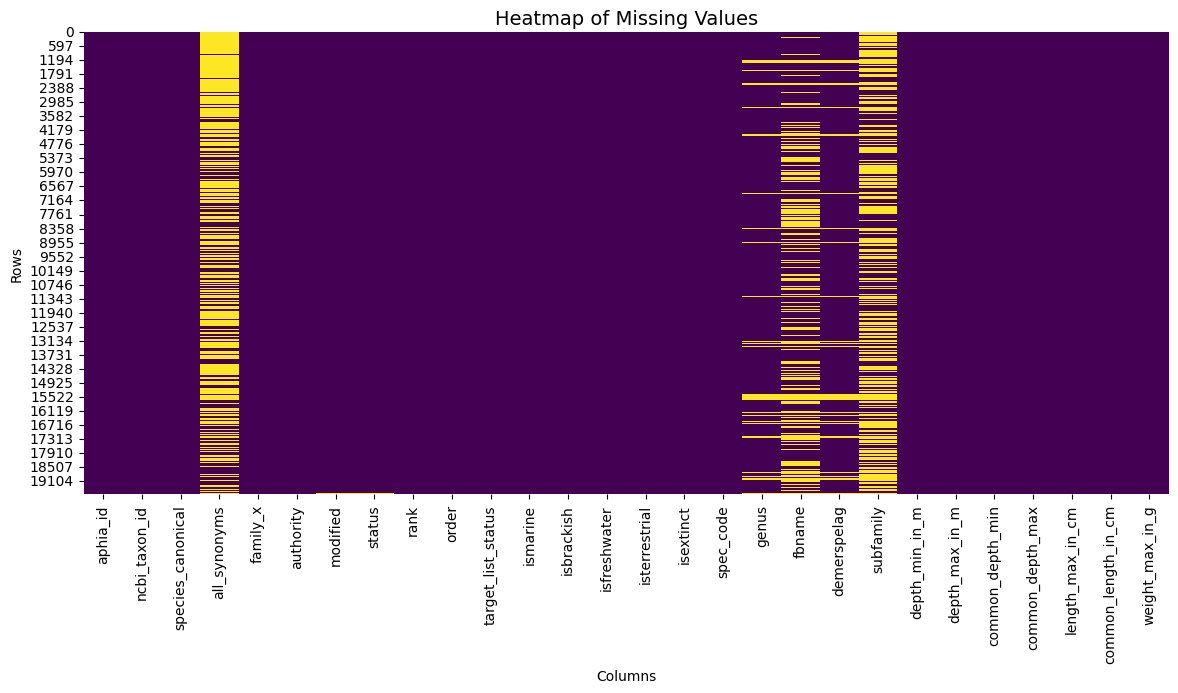

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (change the filename if needed)
df = pd.read_csv("new_final_species_cleaned.csv")  # or use new_final_species.csv

# Plot heatmap of missing values
plt.figure(figsize=(14, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Heatmap of Missing Values", fontsize=14)
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [20]:
import pandas as pd

# Load dataset
df = pd.read_csv("new_final_species_cleaned.csv")  # change filename if needed

# 1. Check if there are any null values at all
print("Any null values? ", df.isnull().values.any())

# 2. Count total null values
print("Total null values: ", df.isnull().sum().sum())

# 3. Count null values per column
print("\nNull values per column:")
print(df.isnull().sum())

Any null values?  True
Total null values:  32734

Null values per column:
aphia_id                   0
ncbi_taxon_id              0
species_canonical          0
all_synonyms           11740
family_x                   0
authority                  0
modified                  43
status                    43
rank                       0
order                      0
target_list_status         0
ismarine                   0
isbrackish                 0
isfreshwater               0
isterrestrial              0
isextinct                  0
spec_code                  0
genus                   1570
fbname                  6977
demerspelag             1570
subfamily              10791
depth_min_in_m             0
depth_max_in_m             0
common_depth_min           0
common_depth_max           0
length_max_in_cm           0
common_length_in_cm        0
weight_max_in_g            0
dtype: int64


In [21]:
# Drop rows with missing values in key columns
df_cleaned = df.dropna(subset=["genus", "status"])

# OR drop whole columns with too many missing values
df_cleaned = df.drop(columns=["all_synonyms", "subfamily", "fbname"])

In [23]:
# Fill categorical with "Unknown"
df["status"] = df["status"].fillna("Unknown")
df["genus"] = df["genus"].fillna("Unknown")

# Fill numeric with median
df["common_length_in_cm"] = df["common_length_in_cm"].fillna(df["common_length_in_cm"].median())

# Fill date with most common value
df["modified"] = df["modified"].fillna(df["modified"].mode()[0])
print(df.isnull().sum())

aphia_id                   0
ncbi_taxon_id              0
species_canonical          0
all_synonyms           11740
family_x                   0
authority                  0
modified                   0
status                     0
rank                       0
order                      0
target_list_status         0
ismarine                   0
isbrackish                 0
isfreshwater               0
isterrestrial              0
isextinct                  0
spec_code                  0
genus                      0
fbname                  6977
demerspelag             1570
subfamily              10791
depth_min_in_m             0
depth_max_in_m             0
common_depth_min           0
common_depth_max           0
length_max_in_cm           0
common_length_in_cm        0
weight_max_in_g            0
dtype: int64


In [30]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

In [25]:
# 📌 Step 2. Load cleaned dataset
df = pd.read_csv("new_final_species_cleaned.csv")
print("Before imputation shape:", df.shape)
print("Missing values before imputation:\n", df.isnull().sum().sort_values(ascending=False).head(10))

Before imputation shape: (19685, 28)
Missing values before imputation:
 all_synonyms         11740
subfamily            10791
fbname                6977
demerspelag           1570
genus                 1570
status                  43
modified                43
family_x                 0
species_canonical        0
ncbi_taxon_id            0
dtype: int64


In [26]:
# KNN IMPUTATION (for numeric features)
numeric_cols = df.select_dtypes(include=[np.number]).columns

In [27]:
# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

In [28]:
print("\nAfter KNN Imputation (numeric cols):")
print(df[numeric_cols].isnull().sum().sum(), "missing values left in numeric features")


After KNN Imputation (numeric cols):
0 missing values left in numeric features


In [31]:
# REGRESSION IMPUTATION (example: genus)
if "genus" in df.columns:
    # Encode categorical as needed (simple approach: drop NA rows for training)
    temp = df[["genus", "family_x"]].dropna().copy() # Add .copy() to avoid SettingWithCopyWarning

    # Convert categorical 'family_x' to dummy vars
    temp = pd.get_dummies(temp, columns=["family_x"], drop_first=True)

    # Encode the target variable 'genus' numerically
    le = LabelEncoder()
    temp["genus_encoded"] = le.fit_transform(temp["genus"])

    # Train regression model to predict genus from family
    X = temp.drop(["genus", "genus_encoded"], axis=1)
    y = temp["genus_encoded"] # Use the encoded genus as the target

    if not y.empty:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = LinearRegression()
        model.fit(X_train, y_train)

        # Now impute missing genus
        missing_genus_mask = df["genus"].isnull()
        missing_genus = df.loc[missing_genus_mask].copy() # Add .copy()

        if not missing_genus.empty:
            missing_genus_encoded = pd.get_dummies(missing_genus[["family_x"]], drop_first=True)
            # align columns
            missing_genus_encoded = missing_genus_encoded.reindex(columns=X.columns, fill_value=0)

            predicted_genus_encoded = model.predict(missing_genus_encoded)

            # Convert predictions back to original genus names
            # Need to handle potential values outside the range of original labels
            # Round and convert to integer labels
            predicted_genus_labels = np.round(predicted_genus_encoded).astype(int)

            # Ensure predicted labels are within the valid range
            valid_labels = le.classes_
            predicted_genus_labels = np.clip(predicted_genus_labels, 0, len(valid_labels) - 1)


            predicted_genus = le.inverse_transform(predicted_genus_labels)

            # Assign imputed values back to the original DataFrame
            df.loc[missing_genus_mask, "genus"] = predicted_genus

print("\nAfter Regression Imputation (genus):")
print(df["genus"].isnull().sum(), "missing values left in 'genus' column")


After Regression Imputation (genus):
0 missing values left in 'genus' column


In [32]:
print("\nAfter regression imputation (for genus):")
print(df["genus"].isnull().sum(), "missing genus values left")


After regression imputation (for genus):
0 missing genus values left


In [33]:
# Final check
print("\nFinal missing values per column:\n", df.isnull().sum().sort_values(ascending=False).head(10))


Final missing values per column:
 all_synonyms         11740
subfamily            10791
fbname                6977
demerspelag           1570
modified                43
status                  43
species_canonical        0
family_x                 0
rank                     0
ncbi_taxon_id            0
dtype: int64


In [34]:
# Check missing values after imputation
missing_after_knn = df.isnull().sum()
print(missing_after_knn)

aphia_id                   0
ncbi_taxon_id              0
species_canonical          0
all_synonyms           11740
family_x                   0
authority                  0
modified                  43
status                    43
rank                       0
order                      0
target_list_status         0
ismarine                   0
isbrackish                 0
isfreshwater               0
isterrestrial              0
isextinct                  0
spec_code                  0
genus                      0
fbname                  6977
demerspelag             1570
subfamily              10791
depth_min_in_m             0
depth_max_in_m             0
common_depth_min           0
common_depth_max           0
length_max_in_cm           0
common_length_in_cm        0
weight_max_in_g            0
dtype: int64


In [35]:
# Numerical columns
print(df.describe())

# Categorical columns
print(df.describe(include=['object']))

           aphia_id  ncbi_taxon_id      ismarine    isbrackish  isfreshwater  \
count  1.968500e+04   1.968500e+04  19685.000000  19685.000000  19685.000000   
mean   4.011479e+05   1.098786e+06      0.997511      0.126391      0.050394   
std    3.574291e+05   8.049097e+05      0.049831      0.332298      0.218762   
min    1.011700e+05   7.748000e+03      0.000000      0.000000      0.000000   
25%    2.713590e+05   4.261000e+05      1.000000      0.000000      0.000000   
50%    2.769940e+05   9.902270e+05      1.000000      0.000000      0.000000   
75%    2.829330e+05   1.609324e+06      1.000000      0.000000      0.000000   
max    1.751406e+06   3.127111e+06      1.000000      1.000000      1.000000   

       isterrestrial  isextinct     spec_code  depth_min_in_m  depth_max_in_m  \
count   19685.000000    19685.0  19685.000000    19685.000000    19685.000000   
mean        0.029870        0.0  30663.584455      115.186462      391.465812   
std         0.170234        0.0  246

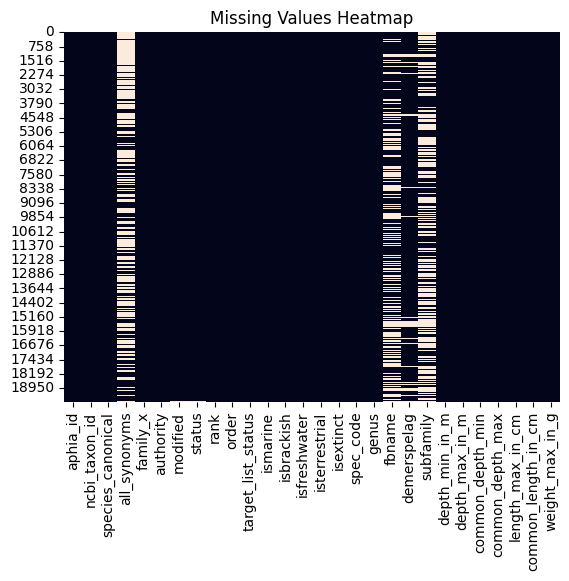

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

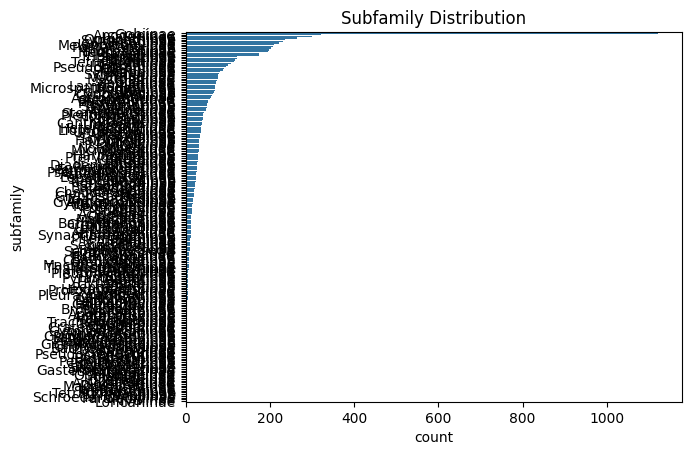

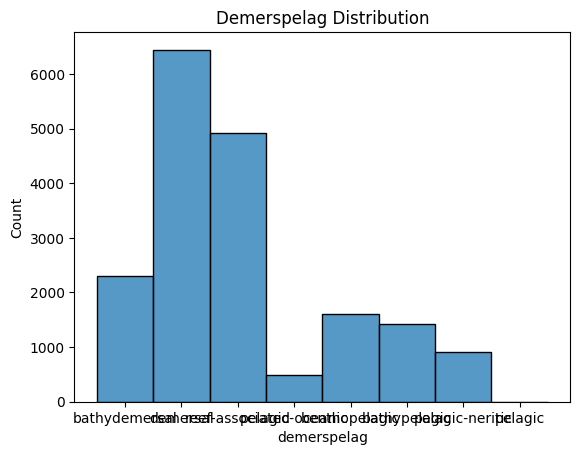

In [40]:
# Count plot for categorical columns
sns.countplot(y='subfamily', data=df, order=df['subfamily'].value_counts().index)
plt.title("Subfamily Distribution")
plt.show()

# Distribution for numerical/binary columns
sns.histplot(df['demerspelag'], bins=500)
plt.title("Demerspelag Distribution")
plt.show()

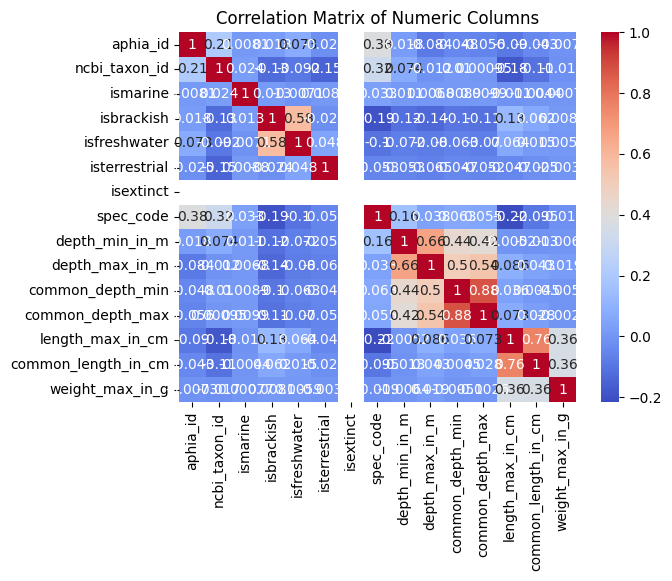

In [41]:
# Correlation for numerical columns
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

In [42]:
# Check missing values per column
print(df.isnull().sum())

aphia_id                   0
ncbi_taxon_id              0
species_canonical          0
all_synonyms           11740
family_x                   0
authority                  0
modified                  43
status                    43
rank                       0
order                      0
target_list_status         0
ismarine                   0
isbrackish                 0
isfreshwater               0
isterrestrial              0
isextinct                  0
spec_code                  0
genus                      0
fbname                  6977
demerspelag             1570
subfamily              10791
depth_min_in_m             0
depth_max_in_m             0
common_depth_min           0
common_depth_max           0
length_max_in_cm           0
common_length_in_cm        0
weight_max_in_g            0
dtype: int64


In [43]:
# Returns True if any null exists
print(df.isnull().any().any())

True


In [50]:
import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np

# Load your dataset
df = pd.read_csv("new_final_species.csv")

# Apply initial cleaning steps from clean_species_dataset function
# (assuming these functions are defined earlier in the notebook and work correctly)
# Standardize column names first
df = standardize_column_names(df)
# Replace placeholders
df = replace_placeholders(df, placeholders=["-"])
# Trim text columns
text_cols = df.select_dtypes(include="object").columns.tolist()
df = trim_and_normalize_text(df, text_cols)
# Normalize species/genus names
if "species_canonical" in df.columns:
    df["species_canonical"] = df["species_canonical"].apply(clean_species_canonical)
if "genus" in df.columns:
    df["genus"] = df["genus"].astype(str).str.strip().replace({"nan": np.nan}).apply(lambda x: x.capitalize() if pd.notna(x) else np.nan)
# Convert numeric cols
default_numeric = [
    "aphia_id", "ncbi_taxon_id", "spec_code",
    "depth_min_in_m", "depth_max_in_m", "common_depth_min", "common_depth_max",
    "length_max_in_cm", "common_length_in_cm", "weight_max_in_g",
    "tempmin", "tempmax"
]
numeric_to_convert = [c for c in default_numeric if c in df.columns]
df = convert_numeric_columns(df, numeric_to_convert)
# Convert integer cols
int_cols = [c for c in ["aphia_id", "ncbi_taxon_id", "spec_code"] if c in df.columns]
df = convert_integer_columns(df, int_cols)
# Convert boolean flags
flag_cols = [c for c in ["ismarine", "isbrackish", "isfreshwater", "isterrestrial", "isextinct"] if c in df.columns]
df = convert_boolean_flags(df, flag_cols)
# Convert datetime columns
dt_cols = [c for c in ["modified"] if c in df.columns]
df = convert_datetime_columns(df, dt_cols)
# Drop high missing columns - this will remove 'publication_id', 'subspecies', 'sequencing_status', 'tempmin', 'tempmax', 'fbname', 'subfamily', 'demerspelag' based on the default threshold and previous runs
df = drop_high_missing(df, thresh=0.95) # Using the same threshold as in pvwSsL6JymyD

# Now proceed with imputation on the reduced DataFrame

# -----------------------------
# Step 1: Identify columns by type after initial cleaning
# -----------------------------
# Re-identify categorical and numerical columns after dropping
categorical_cols = df.select_dtypes(include="object").columns.tolist()
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()


# -----------------------------
# Step 2: Impute numerical columns using KNN (only those with missing values)
# -----------------------------
# Identify numeric columns with missing values
numeric_cols_with_missing = df[numeric_cols].columns[df[numeric_cols].isnull().any()].tolist()

if numeric_cols_with_missing: # Check if there are numeric columns with missing values
    imputer = KNNImputer(n_neighbors=5)
    df[numeric_cols_with_missing] = imputer.fit_transform(df[numeric_cols_with_missing])

# -----------------------------
# Explicitly impute 'modified' and 'status' after KNN (as a failsafe)
# -----------------------------
if 'modified' in df.columns:
    df['modified'] = df['modified'].fillna("Unknown Date") # Use a specific placeholder for date
if 'status' in df.columns:
    df['status'] = df['status'].fillna("Unknown Status") # Use a specific placeholder for status


# -----------------------------
# Step 3: Impute remaining categorical columns with a placeholder (only those with missing values)
# -----------------------------
# Identify categorical columns with missing values
categorical_cols_with_missing = df[categorical_cols].columns[df[categorical_cols].isnull().any()].tolist()

if categorical_cols_with_missing: # Check if there are categorical columns with missing values
    df = impute_categorical(df, categorical_cols_with_missing, fill_value="Unknown")


# -----------------------------
# Step 4: Verify no missing values remain
# -----------------------------
print("Missing values after cleaning:\n", df.isnull().sum())
print("\nAny nulls left?:", df.isnull().any().any())

# -----------------------------
# Step 5: Save the fully cleaned dataset
# -----------------------------
df.to_csv("new_final_species_cleaned.csv", index=False)
print("Cleaned dataset saved as 'new_final_species_cleaned.csv'")

/tmp/ipython-input-412280669.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(placeholders + ["None", "none"], np.nan)


Dropping columns with >95% missing: ['publication_id', 'subspecies', 'sequencing_status', 'tempmin', 'tempmax']
Missing values after cleaning:
 aphia_id               0
ncbi_taxon_id          0
species_canonical      0
all_synonyms           0
family_x               0
authority              0
modified               0
status                 0
rank                   0
order                  0
target_list_status     0
ismarine               0
isbrackish             0
isfreshwater           0
isterrestrial          0
isextinct              0
spec_code              0
genus                  0
fbname                 0
demerspelag            0
subfamily              0
depth_min_in_m         0
depth_max_in_m         0
common_depth_min       0
common_depth_max       0
length_max_in_cm       0
common_length_in_cm    0
weight_max_in_g        0
dtype: int64

Any nulls left?: False
Cleaned dataset saved as 'new_final_species_cleaned.csv'
